# Updates

* Fixed vocab size (was way too small before)
* Saved preprocessed X-train separately
* Decreased ffn size to limit overfitting (memorizing training data)
* Moved model def to subclass
* Now removing punctuation
* Additional regularization (L2 and more dropout)

---

# Setup

##### Imports

In [1]:
import os

import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

##### Set Root Dir as CWD

In [2]:
# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


# Load

In [3]:
num_samples = 500_000

In [4]:
path = "data/yelp/reviews/"

In [5]:
%%time
# Load dev set (10% of total data) as train
train = pd.read_pickle(path + "train.xz").iloc[:num_samples]

CPU times: total: 27.9 s
Wall time: 28.1 s


In [6]:
%%time
# Load test set (10% of total data) as test
test = pd.read_pickle(path + "test.xz").iloc[:100_000]

CPU times: total: 3.48 s
Wall time: 3.56 s


In [7]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
6757466,Been there twice and twice is two to many. Peo...,1
4215725,I gave you 1 star because that's the minimum y...,1
5537655,I drove 3 hours to visit the Christmas Village...,4
1247879,The food and wine/ beer options were awesome b...,2


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

##### Create Pipeline

In [9]:
# Requires download
#   $ python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser"])

In [10]:
print(nlp.analyze_pipes(pretty=True))


============================= Pipeline Overview =============================

#   Component         Assigns          Requires   Scores          Retokenizes
-   ---------------   --------------   --------   -------------   -----------
0   tok2vec           doc.tensor                                  False      
                                                                             
1   tagger            token.tag                   tag_acc         False      
                                                                             
2   attribute_ruler                                               False      
                                                                             
3   lemmatizer        token.lemma                 lemma_acc       False      
                                                                             
4   ner               doc.ents                    ents_f          False      
                      token.ent_iob               ents_p      

In [11]:
i = 9

# Get a single sentence as an example
example = [test["text"].iloc[i]]

# Create a spacy doc with the example
example_doc = list(nlp.pipe(example))[0]
print(example_doc)

Great prices and a fabulous team to help with all your fabric needs! I've especially enjoyed working with the owner Kathy! Beautiful cushions, valances, drapes, and pillows!


In [12]:
# Tokenization example
for token in example_doc:
    print("[" + token.text + "]", end="")

[Great][prices][and][a][fabulous][team][to][help][with][all][your][fabric][needs][!][I]['ve][especially][enjoyed][working][with][the][owner][Kathy][!][Beautiful][cushions][,][valances][,][drapes][,][and][pillows][!]

In [13]:
for token in example_doc:
    # Print text, simple POS, detailed POS, shape, whether alphabetical, whether stopword
    print("[", token.text, token.lemma_, token.pos_, token.tag_,
          token.shape_, token.is_alpha, token.is_stop, "]", end="")

[ Great great ADJ JJ Xxxxx True False ][ prices price NOUN NNS xxxx True False ][ and and CCONJ CC xxx True True ][ a a DET DT x True True ][ fabulous fabulous ADJ JJ xxxx True False ][ team team NOUN NN xxxx True False ][ to to PART TO xx True True ][ help help VERB VB xxxx True False ][ with with ADP IN xxxx True True ][ all all DET DT xxx True True ][ your your PRON PRP$ xxxx True True ][ fabric fabric NOUN NN xxxx True False ][ needs need NOUN NNS xxxx True False ][ ! ! PUNCT . ! False False ][ I I PRON PRP X True True ][ 've 've AUX VBP 'xx False True ][ especially especially ADV RB xxxx True False ][ enjoyed enjoy VERB VBN xxxx True False ][ working work VERB VBG xxxx True False ][ with with ADP IN xxxx True True ][ the the DET DT xxx True True ][ owner owner NOUN NN xxxx True False ][ Kathy Kathy PROPN NNP Xxxxx True False ][ ! ! PUNCT . ! False False ][ Beautiful beautiful ADJ JJ Xxxxx True False ][ cushions cushion NOUN NNS xxxx True False ][ , , PUNCT , , False False ][ valan

In [14]:
# Named entity recognition
for ent in example_doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Kathy 116 121 PERSON


##### Define Preprocessing Steps

In [15]:
def normalize(doc):
    """Preprocesses a spacy Doc.
    
    Currently tokenizes, lemmatizes, and removes stopwords
    """
    output = list()
    for token in doc:
        if not token.is_stop and token.is_alpha:
            output.append(str(token.lemma_))
    
    return output

In [16]:
def apply_normalize(docs, batch_size=1_000, n_processes=1):
    """Applies preprocessing steps to iterable of spacy Docs."""
    results = []
    for doc in nlp.pipe(docs, n_process=n_processes):
        results.append(normalize(doc))
    return results

##### Preprocessing

In [17]:
%%time
# Lowercase
X_train_norm = train["text"].str.lower()
X_test_norm = test["text"].str.lower()

# Remove punctuation
X_train_norm = X_train_norm.str.replace(r'[^\w\s]+', '')
X_test_norm = X_test_norm.str.replace(r'[^\w\s]+', '')

# Set multiprocessing params
batch_size = 2000
n_processes = 4

# Preprocess reviews
X_train_norm = apply_normalize(X_train_norm, batch_size=batch_size, n_processes=n_processes)
X_test_norm = apply_normalize(X_test_norm, batch_size=batch_size, n_processes=n_processes)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:7: FutureWarning: The default value of regex will change from True to False in a future version.


CPU times: total: 5min 55s
Wall time: 15min 29s


##### Convert to Sequence Tensor

In [18]:
maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

# Convert lists of words to vectors of numbers
tokenizer = keras.preprocessing.text.Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_norm)
X_train_seq = tokenizer.texts_to_sequences(X_train_norm)
X_test_seq = tokenizer.texts_to_sequences(X_test_norm)

# Pad sentences to be the same length
X_train_seq = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq = keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=maxlen)

# Convert to tensors for Keras
X_train = tf.convert_to_tensor(X_train_seq)
X_test = tf.convert_to_tensor(X_test_seq)

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Embedding Layer Definition

In [39]:
class TokenAndPositionEmbedding(layers.Layer):
    """Pre-transformer layer."""
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)

        x = self.token_emb(x)
        return x + positions

##### Transformer Layer Definition

In [48]:
class TransformerBlock(layers.Layer):
    """Transformer for embedding."""
    def __init__(self, embed_dim, num_heads, ff_dims, reg, dropout):
        super(TransformerBlock, self).__init__()
        
        # Attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        # Feed-forward network with a layer for each number of neurons in ff_dims
        ffn_layers = []
        for dim in ff_dims:
            layer = layers.Dense(dim, activation="relu", 
                                 kernel_regularizer=keras.regularizers.l2(reg))
            ffn_layers.append(layer)
        self.ffn = keras.Sequential(ffn_layers)
        
        # Speed and regularization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training):
        # Calculate attention and get output
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

##### Model Definition

In [56]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dims,
                 reg=1e-3, dropout=0.3):
        super().__init__()
        
        self.inputs = layers.Input(shape=(maxlen,))
        
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dims,
                                                  reg, dropout)
        
        self.pool = layers.GlobalAveragePooling1D()
        self.dropout1 = layers.Dropout(dropout)
        self.dense = layers.Dense(20, activation="relu", 
                                  kernel_regularizer=keras.regularizers.l2(reg))
        self.dropout2 = layers.Dropout(dropout)
        
        self.stars = layers.Dense(5, activation="softmax")
        
    def call(self, x, training=False):
        # Embed tokens and positional encodings
        x = self.embedding_layer(x)
        
        # Transformer (w/ ffn)
        x = self.transformer_block(x)
        
        # Pooling, dropout, one more dense layer
        x = self.pool(x)
        if training:
            x = self.dropout1(x)
        x = self.dense(x)
        if training:
            x = self.dropout2(x)
            
        # Softmax for 5-star rating probabilities
        return self.stars(x)

##### Create Model

In [72]:
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 5.0e-3
dropout = 0.4

# Model
model = SentimentClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [73]:
# Example outputs (probabilities of each star rating)
model.predict(X_train[:10])

1/1 [==============================] - 0s 128ms/step


array([[0.13313493, 0.18192641, 0.39336264, 0.11014675, 0.18142924],
       [0.12389985, 0.17646822, 0.4179409 , 0.10124663, 0.18044443],
       [0.11158582, 0.16756935, 0.45706943, 0.08782801, 0.17594743],
       [0.12549524, 0.17863399, 0.40447825, 0.10777696, 0.1836156 ],
       [0.11100307, 0.16534248, 0.46049458, 0.08600409, 0.17715584],
       [0.11692494, 0.17684558, 0.4362394 , 0.10273361, 0.16725644],
       [0.16323902, 0.18841852, 0.32073545, 0.13446   , 0.19314696],
       [0.1159181 , 0.1754276 , 0.43717545, 0.09701914, 0.17445982],
       [0.12013881, 0.16745855, 0.44260693, 0.08999055, 0.17980514],
       [0.10809352, 0.16591546, 0.46268582, 0.08837666, 0.17492856]],
      dtype=float32)

##### Compile and Run

In [74]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [75]:
%%time
# Train model
epochs = 10

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Checkpoint
checkpoint_path = "model_checkpoints/proto.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping], verbose=1,
)

Epoch 1/10
15625/15625 [==============================] - 60s 4ms/step - loss: 0.8889 - accuracy: 0.6419 - val_loss: 0.8094 - val_accuracy: 0.6649
Epoch 2/10
15625/15625 [==============================] - 59s 4ms/step - loss: 0.8212 - accuracy: 0.6623 - val_loss: 0.8081 - val_accuracy: 0.6613
Epoch 3/10
15625/15625 [==============================] - 61s 4ms/step - loss: 0.8034 - accuracy: 0.6685 - val_loss: 0.7875 - val_accuracy: 0.6760
Epoch 4/10
15625/15625 [==============================] - 58s 4ms/step - loss: 0.7891 - accuracy: 0.6735 - val_loss: 0.7974 - val_accuracy: 0.6699
Epoch 5/10
15625/15625 [==============================] - 58s 4ms/step - loss: 0.7788 - accuracy: 0.6771 - val_loss: 0.8026 - val_accuracy: 0.6713
Epoch 6/10
15625/15625 [==============================] - 59s 4ms/step - loss: 0.7675 - accuracy: 0.6823 - val_loss: 0.8140 - val_accuracy: 0.6647
Epoch 7/10
15625/15625 [==============================] - 58s 4ms/step - loss: 0.7591 - accuracy: 0.6849 - val_loss: 0

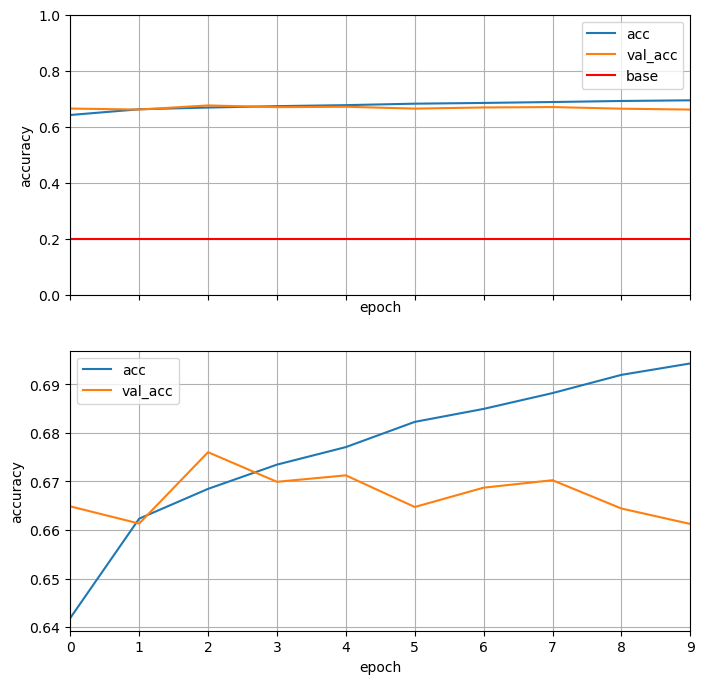

In [76]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Test

In [33]:
# Get probabilities per class
y_pred = model.predict(X_test)

3125/3125 [==============================] - 4s 1ms/step


In [34]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [35]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to 0.2)")

multi-class accuracy: 0.64686
(compare to 0.2)


In [36]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to 0.5)")

binary accuracy: 0.89448
(compare to 0.5)
